In [1]:
# This class only tests whether tensorflow and autograd both calculate the hessian-vector-products identically.

In [2]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from optimizers.autograd.lma import LMA as LMAag
from optimizers.tensorflow.lma import LMA as LMAtf

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def rosenbrock(x):
    x_reshaped = np.reshape(x, [2, -1])
    return np.sum(100*(x_reshaped[1] - x_reshaped[0]**2)**2 + (1 - x_reshaped[0])**2)

In [5]:
x_fn = lambda z: z
z_init = np.zeros(10)

In [6]:
# Autograd
lma_ag = LMAag(z_init, x_fn, rosenbrock, squared_loss=False, cg_tol=1e-5, max_cg_iter=20)

In [7]:
ag_losses = []
for i in range(100):
    out = lma_ag.minimize()
    lossval = rosenbrock(x_fn(out))
    ag_losses.append(lossval)
    if i % 10 == 0: print(lossval)

4.076963604450884
0.6510886357552026
0.2189938396265485
0.0886051407969368
0.039006036910478756
0.01798930823209718
0.008533942718984886
0.004122182552206707
0.002015092060651396
0.0009930534559208812


In [8]:
out

array([0.98973418, 0.98973418, 0.98973418, 0.98973418, 0.98973418,
       0.97953229, 0.97953229, 0.97953229, 0.97953229, 0.97953229])

In [9]:
# Tensorflow
tf.reset_default_graph()
tf_var = tf.Variable(z_init, dtype='float32')
tf_x_fn = lambda x: tf.identity(x)
tf_x_fn_tensor = tf_x_fn(tf_var)

def tf_rosenbrock(x):
    x_reshaped = tf.reshape(x, [2, -1])
    return tf.reduce_sum(100*(x_reshaped[1] - x_reshaped[0]**2)**2 + (1 - x_reshaped[0])**2)

tf_rosenbrock_tensor = tf_rosenbrock(tf_x_fn_tensor)

lma_tf = LMAtf(tf_var, tf_x_fn, tf_rosenbrock, name='ros', squared_loss=False, cg_tol=1e-5, max_cg_iter=20)
minimizer = lma_tf.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
tf_losses = []
for i in range(100):
    session.run(minimizer)
    lossval = session.run(tf_rosenbrock_tensor)
    #session.run(damping_update, feed_dict={placeholder:lossval})
    tf_losses.append(lossval)

In [12]:
tf_losses[:5], ag_losses[:5]

([4.0769634, 2.8182025, 2.2718801, 1.8757492, 1.5666525],
 [4.076963604450884,
  2.818201842449017,
  2.2718799276233637,
  1.8757491522782797,
  1.5666520357620841])

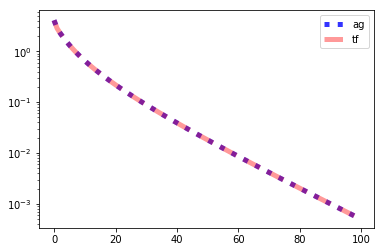

In [41]:
# The discrepancy here is because curveball requires a matrix inversion step
# the matrix becomes singular fairly often
# I tried calculating the pseudo inverse myself, but all the approach I tried for this 
# in tensorflow game solutions less stable and accurate than the numpy counterpart.
plt.plot(ag_losses, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag')
plt.plot(tf_losses, color='red', ls='--', linewidth=5.0, alpha=0.4, label='tf')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [42]:
# Solution is all ones
session.run(lma_tf._damping_factor)

11.390625

In [43]:
lma_ag._damping_factor

11.390625